## 데이터 수집 및 Visualization

In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


In [ ]:
# 데이터 준비 (받아옴)
!mkdir -p ~/aiffel/medical
!ln -s ~/data/* ~/aiffel/medical

In [2]:
# e데이터셋 분리
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [3]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


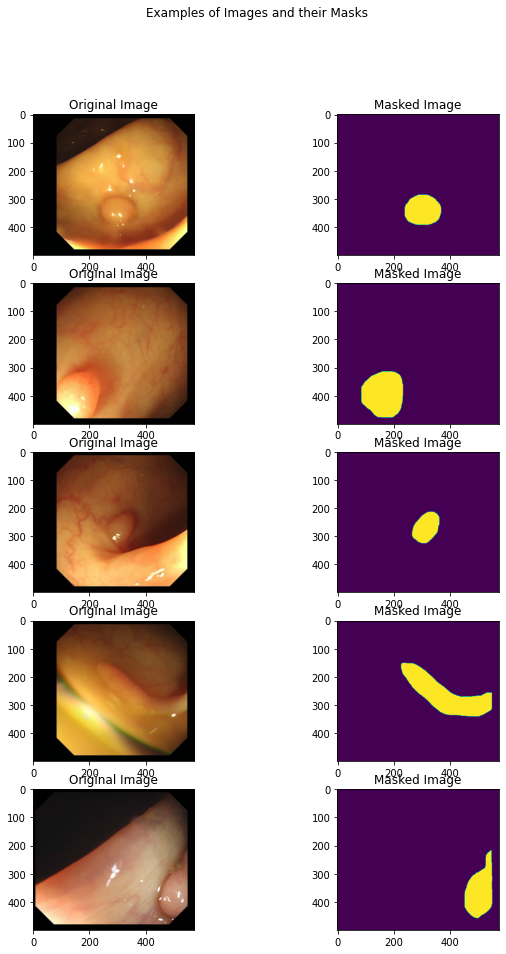

In [4]:
# 시각화
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

## Data pipeline and Preprocessing

In [5]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 4     # 8이였으나 모델이 훈련 중에 GPU 메모리를 초과로 낮춤
max_epochs = 10

***tf.data를 활용한 입력 파이프라인 설계***  
tf.data.Dataset을 이용해 데이터셋 구축, 배치처리 등을 진행. 이 과정에서 다양한 함수를 map에 적용하여 Data Augmentation을 함께 구현할 것  

과정

1. 이미지와 레이블 모두 파일 이름에서 파일의 바이트를 읽음. 라벨은 실제로 각 픽셀이 용종데이터로 (1, 0)으로 주석이 달린 이미지.
2. 바이트를 이미지 형식으로 디코딩.
3. _augment 함수를 통한 이미지 변환 적용 : (optional, input parameters에 따라서)
 - resize-이미지를 표준 크기로 조정 (eda 또는 계산 / 메모리 제한에 의해 결정됨)
 - resize의 이유는 U-Net이 fully convolution networks 이므로 입력 크기에 의존하지 않기 때문. 그러나 이미지 크기를 조정하지 않으면 가변 이미지 크기를 함께 배치 할 수 없으므로 배치 크기 1을 사용해야함.
 - 성능에 영향을 줄 수 있으므로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정할 수도 있음. 
 - *hue_delta-RGB* 이미지의 색조를 랜덤 팩터로 조정. 이것은 실제 이미지에만 적용가능 (라벨 이미지가 아님). *hue_delta*는[0, 0.5]간격에 있어야함.
 - *horizontal_flip*-0.5 확률로 중심 축을 따라 이미지를 수평으로 뒤집음. 이 변환은 레이블과 실제 이미지 모두에 적용해야함.
 - *width_shift_range* 및*height_shift_range*는 이미지를 가로 또는 세로로 임의로 변환하는 범위 (전체 너비 또는 높이의 일부). 이 변환은 레이블과 실제 이미지 모두에 적용해야 함.
 - *rescale*-이미지를 일정한 비율로 다시 조정 (예 : 1/255.)
4. 데이터를 섞고, 데이터를 반복하여 학습함.
***Data augmentation의 필요성***  
Data augmentation은 딥러닝을 이용한 이미지 처리분야 (classification, detection, segmentation 등) 에서 널리 쓰이는 테크닉임. 의료영상 처리와 같이 데이터 갯수가 부족한 경우 이런 기법이 큰 힘을 발휘함.  

- 데이터 증가는 여러 무작위 변환을 통해 데이터를 증가시켜 훈련 데이터의 양을 "증가"시킴.
- 훈련 시간 동안 우리 모델은 똑같은 그림을 두 번 볼 수 없음. 따라서 Overfitting을 방지하고, 모델이 처음보는 데이터에 대해 더 잘 일반화되도록 도와줌.

---

***Processing each pathname***  
실제 이미지 데이터를 로드하는 함수를 구현.

- byte 형태로 데이터를 로드하고, bmp로 디코딩
- 디코딩이 완료된 image를 scale과 size를 조절

In [6]:
# 실제 이미지 데이터를 로드하는 함수
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

***Data augmentation - Shifting the image***

In [7]:
# 로드한 이미지를 기반으로 이미지의 위치를 적절히 이동(shift)시키는 함수
# 입력이미지와 라벨의 쌍을 동일하게 shift시켜주어야 함.
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

***Data augmentation - Flipping the image randomly***

In [8]:
# 로드한 이미지를 기반으로 이미지를 flip하는 함수
# 50%의 확률로 좌우반전만 구현하였고, 상하반전은 적용하지 않음
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

***Data augmentation Assembling***

In [9]:
# Augmentation용 함수를 이용해 Data augmentation에 사용하는 _augment() 함수를 구성
# 추가로 resize, hue_delta가 적용됨.
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

***Set up train and test datasets***

In [10]:
# tf.data.Dataset을 이용하여 데이터셋 배치구성, 셔플링 등을 구현
# augmentation도 함께 적용됨. 단, Train dataset에서만 Data augmentation을 진행하게 설정하는 것에 주의
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [11]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

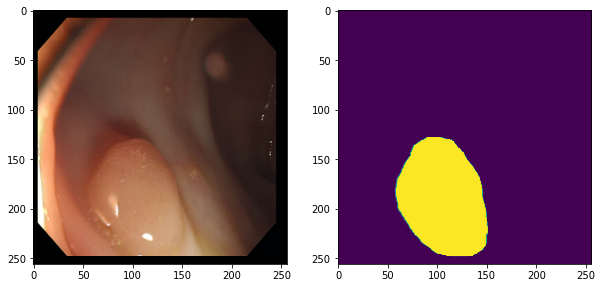

In [12]:
# 학습데이터 확인 (data augmentation 효과가 잘 적용되었는가?)
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

## Build the model  

***Encoder - Decoder***

In [13]:
# Encoder
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [14]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(4, 16, 16, 512)


In [15]:
# Decoder
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [16]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(4, 256, 256, 1)


In [17]:
# 모델 구성
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

***U-Net***  

- U-Net은 Encoder-Decoder 구조와는 달리 해당 레이어의 outputs이 바로 다음 레이어의 inputs이 되지 않음. 위에 Encoder-Decoder 모델처럼 tf.keras.Sequential()을 쓸 수가 없음.

- Sequential 구조가 아닌 네트워크를 만들 때 쓸 수 있는 API >> tf.keras functional API . U-Net 구현을 위해 Model subclassing 방식을 사용하여, tf.keras.Model 클래스를 상속하여 구현할 것 임.

In [18]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [19]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [20]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [21]:
# U-net 모델 구현
unet_model = UNet()

***metrics과 loss functions 정의하기***  
사용해볼 손실함수  

- binary cross entropy

- dice_loss
 
- Cross-entropy loss와 Dice loss를 같이 사용해 meanIoU를 더 올리도록 학습 가능.

In [22]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

# Dice Loss가 최대화되는 방향으로 구해지도록, 아래와 같이 사용.
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

# 새로운 Loss function을 사용하기위해서 
# 기존에 사용하였던 Binary crossentropy loss와 새로 구현한 Dice loss를 더하는 방식으로 구성
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [23]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

***Select a model***

In [24]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요. 

# Encoder-Decoder model
print('select the Encoder-Decoder model')
model_ed = ed_model
checkpoint_dir_ed =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

# U-net model
# print('select the U-Net model')
# model = unet_model
# checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the Encoder-Decoder model


In [25]:
# Compile
model_ed.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions_ed = model_ed(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions_ed.shape)

(4, 256, 256, 1)


In [26]:
model_ed.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (4, 16, 16, 512)          4693056   
_________________________________________________________________
decoder (Sequential)         (4, 256, 256, 1)          2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


In [27]:
# U-net model
model_unet = unet_model
checkpoint_dir_unet =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

In [28]:
model_unet.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions_unet = model_unet(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions_unet.shape)

(4, 256, 256, 1)


In [29]:
model_unet.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

***Callbacks***  
- Callback 함수들을 이용하여, 학습 중간에 원하는 동작을 할 수 있도록 함.
    - ModelCheckpoint callback 함수는 모델 학습간 특정 feature를 모니터링하다 기준점을 넘으면 모델 파라미터를 저장하는 역할 수행.
    - LearningRateScheduler callback 함수는 학습을 진행하며, 주어진 인자의 값을 이용해 Learning rate를 조절해주는 함수.
    - cos_decay는 cos 함수의 모양으로 Learning rate를 조절해 주는 learning rate decay 구현.

In [30]:
# Encode-Decoder model
if not os.path.isdir(checkpoint_dir_ed):
    os.makedirs(checkpoint_dir_ed)

cp_callback_ed = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_ed,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [31]:
# U-net model
if not os.path.isdir(checkpoint_dir_unet):
    os.makedirs(checkpoint_dir_unet)

cp_callback_unet = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_unet,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [32]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

## Train your model

In [35]:
## Define print function
def print_images(model):
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

***Training - model.fit() 함수 이용***  
- 위에서 구성한 Train dataset과 Test dataset등을 이용해 학습을 진행.  
- 학습 데이터의 갯수가 부족하기때문에 Test dataset을 Validation dataset으로 사용할 것 임.  

10 Epoch만 학습을 진행한 후, 미리 학습된 모델을 불러올 예정.

In [33]:
# Encoder-Decoder model
history_ed = model_ed.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback_ed, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
60/60 [==============================] - 11s 106ms/step - loss: 1.0661 - dice_loss: 0.7406 - val_loss: 1.2838 - val_dice_loss: 0.8324
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
60/60 [==============================] - 7s 100ms/step - loss: 0.9439 - dice_loss: 0.7073 - val_loss: 1.0526 - val_dice_loss: 0.7973
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
60/60 [==============================] - 7s 102ms/step - loss: 0.9296 - dice_loss: 0.7080 - val_loss: 1.0413 - val_dice_loss: 0.8558
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
60/60 [==============================] - 7s 101ms/step - loss: 0.8922 - dice_loss: 0.6834 - val_loss: 1.1670 - val_di

In [34]:
# U-net model
history_unet = model_unet.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback_unet, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
60/60 [==============================] - 36s 466ms/step - loss: 0.9545 - dice_loss: 0.7255 - val_loss: 2.3794 - val_dice_loss: 0.9082
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
60/60 [==============================] - 29s 467ms/step - loss: 0.8893 - dice_loss: 0.6848 - val_loss: 1.1649 - val_dice_loss: 0.9555
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
60/60 [==============================] - 30s 473ms/step - loss: 0.8797 - dice_loss: 0.6806 - val_loss: 3.3383 - val_dice_loss: 0.8910
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
60/60 [==============================] - 30s 479ms/step - loss: 0.8164 - dice_loss: 0.6260 - val_loss: 1.5386 - val

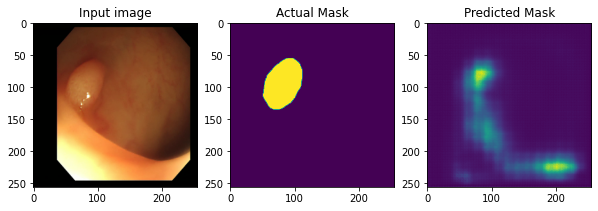

In [36]:
# print sample image after training
print_images(model_ed)

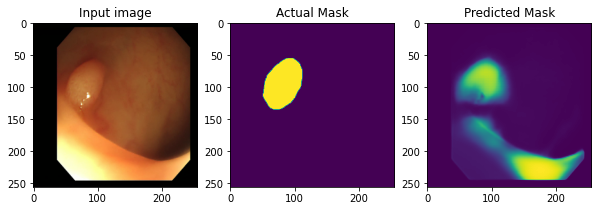

In [37]:
print_images(model_unet)

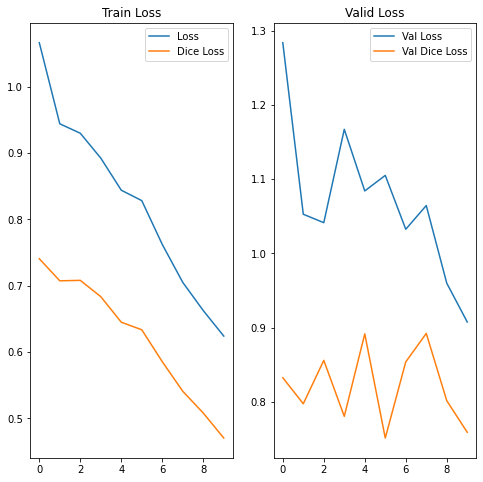

In [38]:
# 저장된 학습 진행과정(history)을 시각화
dice_loss = history_ed.history['dice_loss']
loss = history_ed.history['loss']
val_dice_loss = history_ed.history['val_dice_loss']
val_loss = history_ed.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

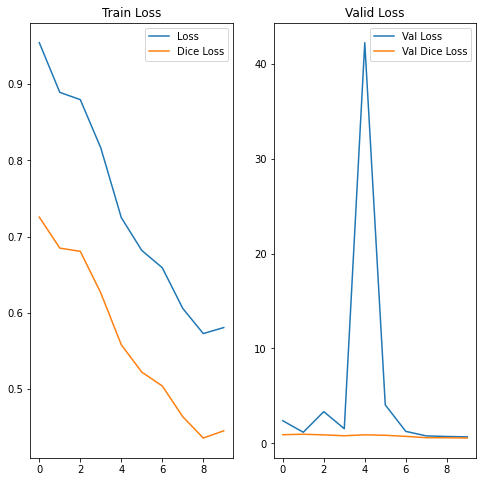

In [39]:
dice_loss = history_unet.history['dice_loss']
loss = history_unet.history['loss']
val_dice_loss = history_unet.history['val_dice_loss']
val_loss = history_unet.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

***Restore the latest checkpoint***

In [40]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
checkpoint_dir_ed = os.path.join(DATASET_PATH, 'train_ckpt/ed_model')
checkpoint_dir_unet = os.path.join(DATASET_PATH, 'train_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model_unet.load_weights(checkpoint_dir_unet)
model_ed.load_weights(checkpoint_dir_ed)

***Evaluate the test dataset***

In [42]:
mean_unet = []
mean_ed = []

for images, labels in test_dataset:
    predictions_unet = model_unet(images, training=False)
    m_unet = mean_iou(labels, predictions_unet)
    mean_unet.append(m_unet)
    
    predictions_ed = model_ed(images, training=False)
    m_ed = mean_iou(labels, predictions_ed)
    mean_ed.append(m_ed)

mean_unet = np.array(mean_unet)
mean_unet = np.mean(mean_unet)
print("mean_iou: {}".format(mean_unet))

mean_ed = np.array(mean_ed)
mean_ed = np.mean(mean_ed)
print("mean_iou: {}".format(mean_ed))

mean_iou: 0.591274664076467
mean_iou: 0.5015430100169094


In [43]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions_unet = model_unet(test_images, training=False)
        predictions_ed = model_ed(test_images, training=False)
        
        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 5, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 5, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 5, 3)
            plt.imshow(predictions_unet[i, :, :, 0])
            plt.title("U-Net Predicted")
            
            plt.subplot(1, 5, 4)
            plt.imshow(predictions_ed[i, :, :, 0])
            plt.title("E-D Predicted")

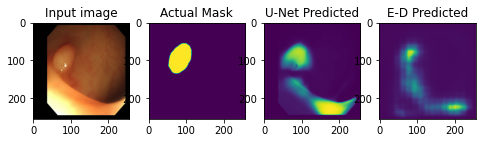

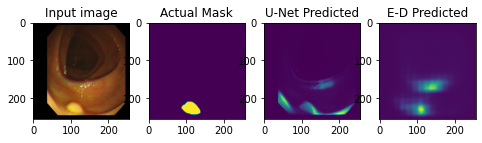

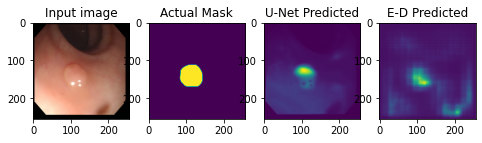

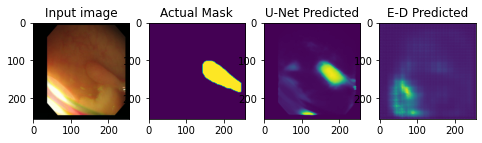

In [44]:
print_images()

In [97]:
from tensorflow.keras.backend import clear_session

# 모델이 훈련 중에 GPU 메모리를 초과발생 메모리 지우기 시도
# 훈련 전 또는 후에 실행
clear_session()

# 효과 없었음

---

# 프로젝트: U-Net 성능 개선해 보기

In [45]:
# 라이브러리 버젼 확인
import tensorflow
import sklearn
import numpy

print(tensorflow.__version__)
print(sklearn.__version__)
print(numpy.__version__)

2.6.0
1.0
1.21.4


In [58]:
# 데이터셋 구성
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [59]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


In [60]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 4
max_epochs = 10

In [61]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

In [49]:
# pretrained model을 활용한 U-Net 모델 구성
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'block3_pool')>,


In [65]:
# Vgg16 model
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

In [66]:
vgg16 = Vgg16UNet()

In [67]:
model_vgg = vgg16
checkpoint_dir_vgg =os.path.join(DATASET_PATH,'train_ckpt/vgg_model')

In [62]:
optimizer = tf.keras.optimizers.Adam()

In [63]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [68]:
model_vgg.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions_vgg = model_vgg(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions_vgg.shape)

(4, 256, 256, 1)


In [69]:
model_vgg.summary()

Model: "vgg16u_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
model_1 (Functional)         [(None, 256, 256, 64), (N 14714688  
_________________________________________________________________
conv_block_6 (ConvBlock)     multiple                  0 (unused)
_________________________________________________________________
decoder_block_8 (DecoderBloc multiple                  9444864   
_________________________________________________________________
decoder_block_9 (DecoderBloc multiple                  2952960   
_________________________________________________________________
decoder_block_10 (DecoderBlo multiple                  739200    
_________________________________________________________________
decoder_block_11 (DecoderBlo multiple                 

In [70]:
if not os.path.isdir(checkpoint_dir_vgg):
    os.makedirs(checkpoint_dir_vgg)

cp_callback_vgg = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_vgg,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [71]:
# 학습과 테스트, 시각화
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [72]:
history_vgg = model_vgg.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback_vgg, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
60/60 [==============================] - 23s 292ms/step - loss: 0.8696 - dice_loss: 0.6297 - val_loss: 4.9313 - val_dice_loss: 1.0000
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
60/60 [==============================] - 19s 289ms/step - loss: 0.7487 - dice_loss: 0.5699 - val_loss: 1.8413 - val_dice_loss: 0.8442
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
60/60 [==============================] - 19s 292ms/step - loss: 0.6835 - dice_loss: 0.5204 - val_loss: 1.8204 - val_dice_loss: 0.8153
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
60/60 [==============================] - 19s 295ms/step - loss: 0.6626 - dice_loss: 0.5057 - val_loss: 1.9033 - val

In [73]:
# Define print function
def print_images(model):
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

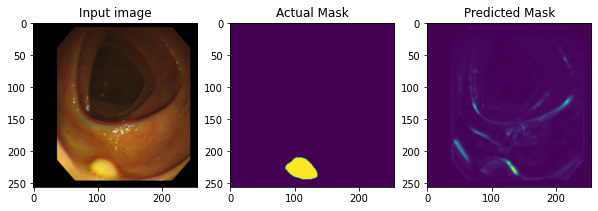

In [74]:
print_images(model_vgg)

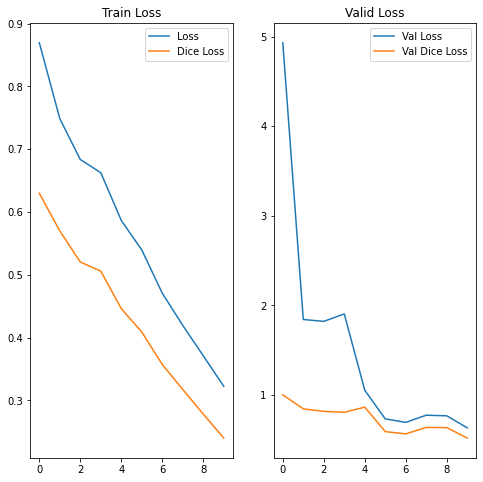

In [75]:
dice_loss = history_vgg.history['dice_loss']
loss = history_vgg.history['loss']
val_dice_loss = history_vgg.history['val_dice_loss']
val_loss = history_vgg.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [76]:
mean_vgg = []
for images, labels in test_dataset:
    predictions_vgg = model_vgg(images, training=False)
    m_vgg = mean_iou(labels, predictions_vgg)
    mean_vgg.append(m_vgg)

mean_vgg = np.array(mean_vgg)
mean_vgg = np.mean(mean_vgg)
print("mean_iou: {}".format(mean_vgg))

mean_iou: 0.6114930882297467


In [77]:
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions_unet = model_unet(test_images, training=False)
        predictions_ed = model_ed(test_images, training=False)
        predictions_vgg = model_vgg(test_images, training=False)
        
        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 5, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 5, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 5, 3)
            plt.imshow(predictions_unet[i, :, :, 0])
            plt.title("U-Net Predicted")
            
            plt.subplot(1, 5, 4)
            plt.imshow(predictions_ed[i, :, :, 0])
            plt.title("E-D Predicted")
            
            plt.subplot(1, 5, 5)
            plt.imshow(predictions_vgg[i, :, :, 0])
            plt.title("VGG Predicted")
            plt.show()

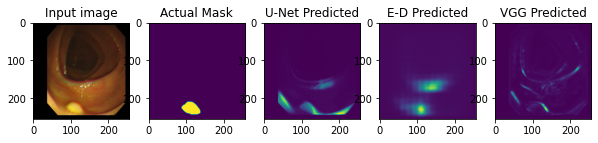

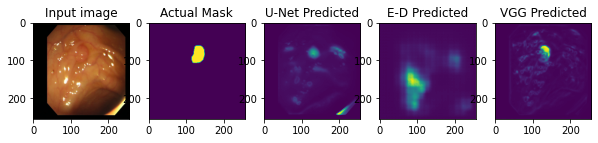

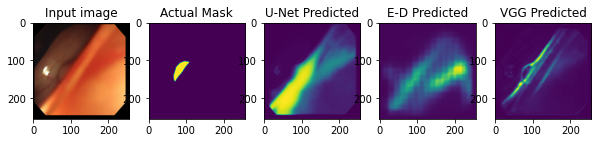

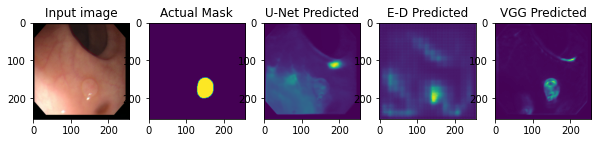

In [78]:
print_images()

In [89]:
# Convolutional Block with Weight Regularization
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_regularizer=tf.keras.regularizers.l2(1e-4)):
        super(ConvBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, 3, padding='same', kernel_regularizer=kernel_regularizer)
        self.conv2 = layers.Conv2D(filters, 3, padding='same', kernel_regularizer=kernel_regularizer)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        return tf.nn.relu(x)

# Decoder Block with Weight Regularization
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_regularizer=tf.keras.regularizers.l2(1e-4)):
        super(DecoderBlock, self).__init__()
        self.up = layers.UpSampling2D(size=(2, 2))
        self.concat = layers.Concatenate()
        self.conv_block = ConvBlock(filters, kernel_regularizer)

    def call(self, inputs, skip, training=True):
        x = self.up(inputs)
        x = self.concat([x, skip])
        return self.conv_block(x, training=training)

# VGG16-based U-Net with Weight Regularization
class Vgg16UNet(tf.keras.Model):
    def __init__(self, img_shape, kernel_regularizer=tf.keras.regularizers.l2(1e-4)):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                                 include_top=False,
                                                 weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2],  # encoder1
                                               layer_outputs[5],  # encoder2
                                               layer_outputs[9],  # encoder3
                                               layer_outputs[13], # encoder4
                                               layer_outputs[17]]) # center

        self.center = ConvBlock(1024, kernel_regularizer)

        self.decoder_block4 = DecoderBlock(512, kernel_regularizer)
        self.decoder_block3 = DecoderBlock(256, kernel_regularizer)
        self.decoder_block2 = DecoderBlock(128, kernel_regularizer)
        self.decoder_block1 = DecoderBlock(64, kernel_regularizer)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid', kernel_regularizer=kernel_regularizer)

    def call(self, inputs, training=True):
        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs)

        decoder4 = self.decoder_block4(center, encoder4, training)
        decoder3 = self.decoder_block3(decoder4, encoder3, training)
        decoder2 = self.decoder_block2(decoder3, encoder2, training)
        decoder1 = self.decoder_block1(decoder2, encoder1, training)
        
        outputs = self.output_conv(decoder1)
        return outputs

# Model instantiation
image_size = 256
img_shape = (image_size, image_size, 3)
model_vgg16_unet = Vgg16UNet(img_shape)

model_vgg16_unet.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions_vgg16_unet = model_vgg16_unet(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions_vgg16_unet.shape)

# Print model summary to verify the architecture
model_vgg16_unet.build(input_shape=(None, *img_shape))
model_vgg16_unet.summary()
checkpoint_dir_vgg16_unet =os.path.join(DATASET_PATH,'train_ckpt/vgg_model')

(4, 256, 256, 1)
Model: "vgg16u_net_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
model_5 (Functional)         [(None, 256, 256, 64), (N 14714688  
_________________________________________________________________
conv_block_22 (ConvBlock)    multiple                  0 (unused)
_________________________________________________________________
decoder_block_24 (DecoderBlo multiple                  7083008   
_________________________________________________________________
decoder_block_25 (DecoderBlo multiple                  2361856   
_________________________________________________________________
decoder_block_26 (DecoderBlo multiple                  591104    
_________________________________________________________________
decoder_block_27 (DecoderBlo multiple

In [90]:
if not os.path.isdir(checkpoint_dir_vgg16_unet):
    os.makedirs(checkpoint_dir_vgg16_unet)

cp_callback_vgg16_unet = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_vgg16_unet,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [123]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

# Dice Loss가 최대화되는 방향으로 구해지도록, 아래와 같이 사용.
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

# 새로운 Loss function을 사용하기위해서 
# 기존에 사용하였던 Binary crossentropy loss와 새로 구현한 Dice loss를 더하는 방식으로 구성
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [124]:
# 모델 컴파일
model_vgg16_unet.compile(
    optimizer=optimizer,
    loss=bce_dice_loss, 
    metrics=[dice_loss]  # 사용자 정의 Dice Loss를 추가
)

In [125]:
history_vgg16_unet = model_vgg16_unet.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback_vgg16_unet, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
60/60 [==============================] - 19s 272ms/step - loss: 0.2770 - dice_loss: 0.1716 - val_loss: 0.7205 - val_dice_loss: 0.4340
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
60/60 [==============================] - 18s 271ms/step - loss: 0.2965 - dice_loss: 0.1882 - val_loss: 0.4767 - val_dice_loss: 0.3223
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
60/60 [==============================] - 18s 275ms/step - loss: 0.2743 - dice_loss: 0.1694 - val_loss: 0.3542 - val_dice_loss: 0.2445
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
60/60 [==============================] - 18s 278ms/step - loss: 0.2432 - dice_loss: 0.1521 - val_loss: 0.6630 - val

In [126]:
def print_images(model):
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0, :, :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

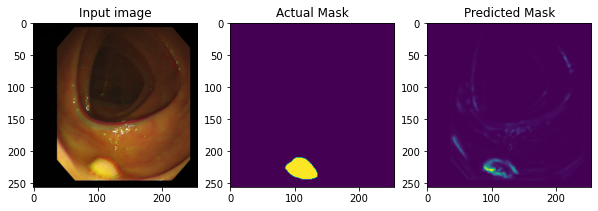

In [108]:
print_images(model_vgg16_unet)

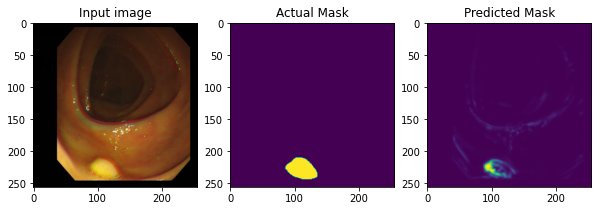

In [127]:
print_images(model_vgg16_unet)

In [128]:
print(history_vgg16_unet.history.keys())

dict_keys(['loss', 'dice_loss', 'val_loss', 'val_dice_loss', 'lr'])


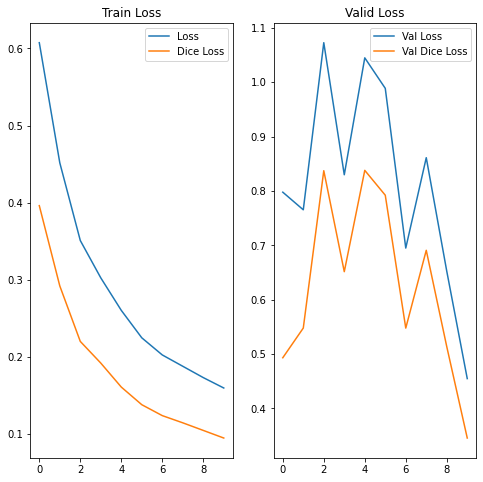

In [110]:
# 1번째 훈련
dice_loss = history_vgg16_unet.history['dice_loss']
loss = history_vgg16_unet.history['loss']
val_dice_loss = history_vgg16_unet.history['val_dice_loss']
val_loss = history_vgg16_unet.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

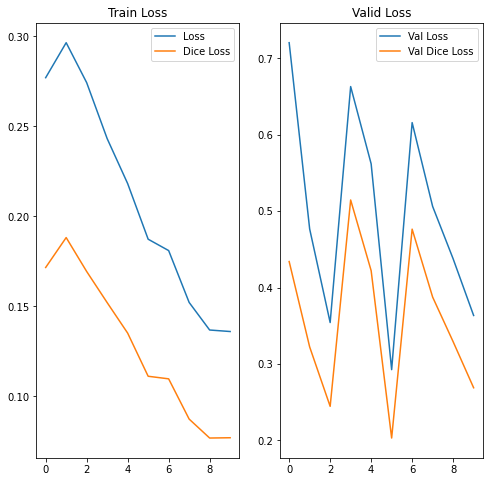

In [129]:
# 2번째 훈련
dice_loss = history_vgg16_unet.history['dice_loss']
loss = history_vgg16_unet.history['loss']
val_dice_loss = history_vgg16_unet.history['val_dice_loss']
val_loss = history_vgg16_unet.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [130]:
checkpoint_dir_vgg16_unet = os.path.join(DATASET_PATH, 'train_ckpt/vgg_model')

# restoring the latest checkpoint in checkpoint_dir
model_vgg16_unet.load_weights(checkpoint_dir_vgg16_unet)

In [112]:
mean_unet = []
mean_ed = []
mean_vgg = []
mean_vgg16_unet = []

for images, labels in test_dataset:
    predictions_unet = model_unet(images, training=False)
    m_unet = mean_iou(labels, predictions_unet)
    mean_unet.append(m_unet)
    
    predictions_ed = model_ed(images, training=False)
    m_ed = mean_iou(labels, predictions_ed)
    mean_ed.append(m_ed)
    
    predictions_vgg = model_vgg(images, training=False)
    m_vgg = mean_iou(labels, predictions_vgg)
    mean_vgg.append(m_vgg)
    
    predictions_vgg16_unet = model_vgg16_unet(images, training=False)
    m_vgg16_unet = mean_iou(labels, predictions_vgg16_unet)
    mean_vgg16_unet.append(m_vgg16_unet)

mean_unet = np.array(mean_unet)
mean_unet = np.mean(mean_unet)
print("mean_iou: {}".format(mean_unet))
# mean_iou: 0.6179826811503071

mean_ed = np.array(mean_ed)
mean_ed = np.mean(mean_ed)
print("mean_iou: {}".format(mean_ed))
# mean_iou: 0.5023448105212941

mean_vgg = np.array(mean_vgg)
mean_vgg = np.mean(mean_vgg)
print("mean_iou: {}".format(mean_vgg))
# mean_iou: 0.6114930882297467

mean_vgg16_unet = np.array(mean_vgg16_unet)
mean_vgg16_unet = np.mean(mean_vgg16_unet)
print("mean_iou: {}".format(mean_vgg16_unet))
# mean_iou: 0.8119433911057286

mean_iou: 0.6179826811503071
mean_iou: 0.5023448105212941
mean_iou: 0.6114930882297467
mean_iou: 0.8119433911057286


In [132]:
# 2번 째 확인
mean_vgg16_unet = []

for images, labels in test_dataset:
    predictions_vgg16_unet = model_vgg16_unet(images, training=False)
    m_vgg16_unet = mean_iou(labels, predictions_vgg16_unet)
    mean_vgg16_unet.append(m_vgg16_unet)

mean_vgg16_unet = np.array(mean_vgg16_unet)
mean_vgg16_unet = np.mean(mean_vgg16_unet)
print("mean_iou: {}".format(mean_vgg16_unet))

mean_iou: 0.8153688569580687


In [133]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions_unet = model_unet(test_images, training=False)
        predictions_ed = model_ed(test_images, training=False)
        predictions_vgg = model_vgg(test_images, training=False)
        predictions_vgg16_unet = model_vgg16_unet(test_images, training=False)
        
        for i in range(batch_size):
            plt.figure(figsize=(15, 10))
            
            plt.subplot(2, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(2, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(2, 3, 3)
            plt.imshow(predictions_unet[i, :, :, 0])
            plt.title("U-Net Predicted")
            
            plt.subplot(2, 3, 4)
            plt.imshow(predictions_ed[i, :, :, 0])
            plt.title("E-D Predicted")
            
            plt.subplot(2, 3, 5)
            plt.imshow(predictions_vgg[i, :, :, 0])
            plt.title("VGG Predicted")
            
            plt.subplot(2, 3, 6)
            plt.imshow(predictions_vgg16_unet[i, :, :, 0])
            plt.title("VGG16_Unet Predicted")
            
            plt.tight_layout()  # 레이아웃 자동 조정
            plt.show()
        plt.show()

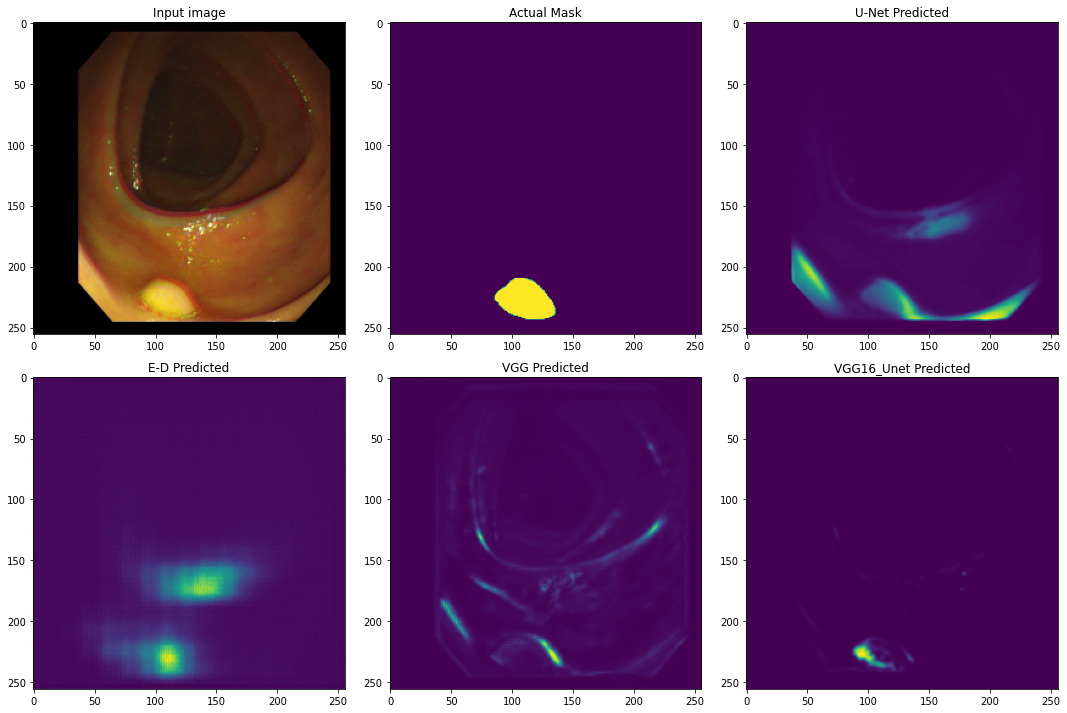

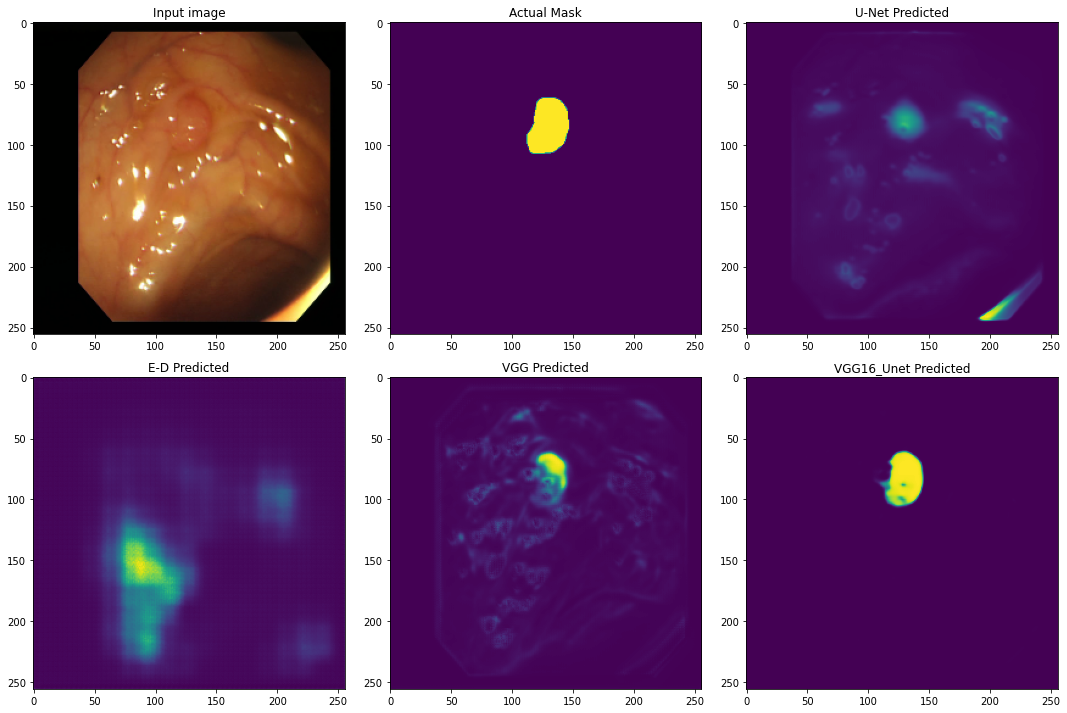

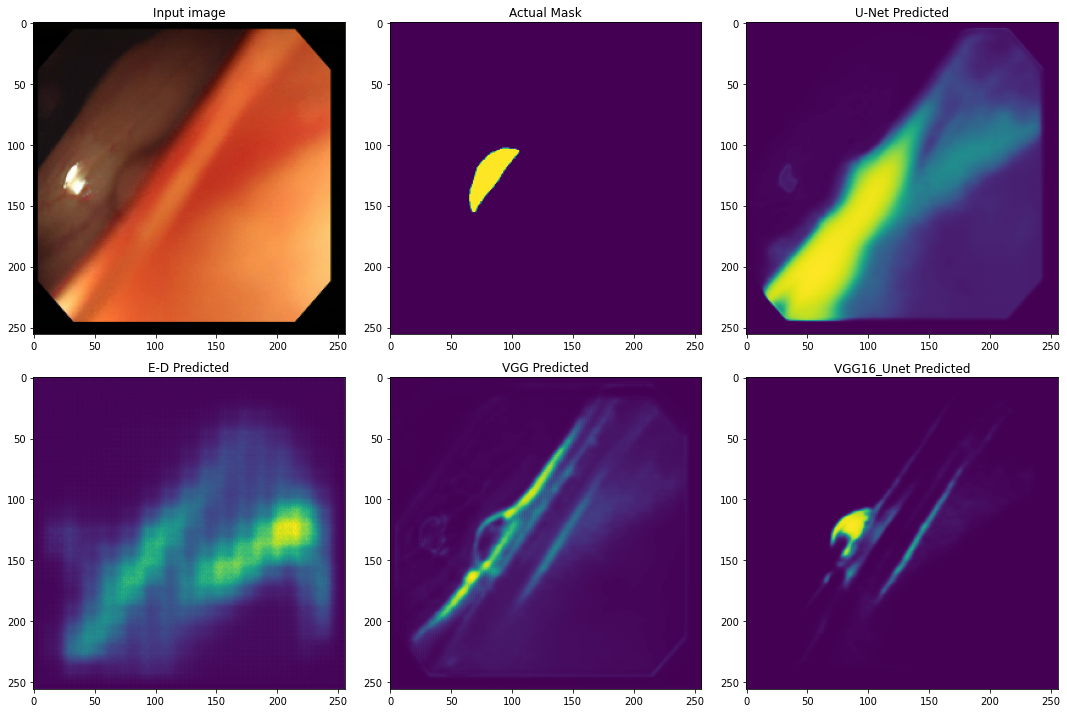

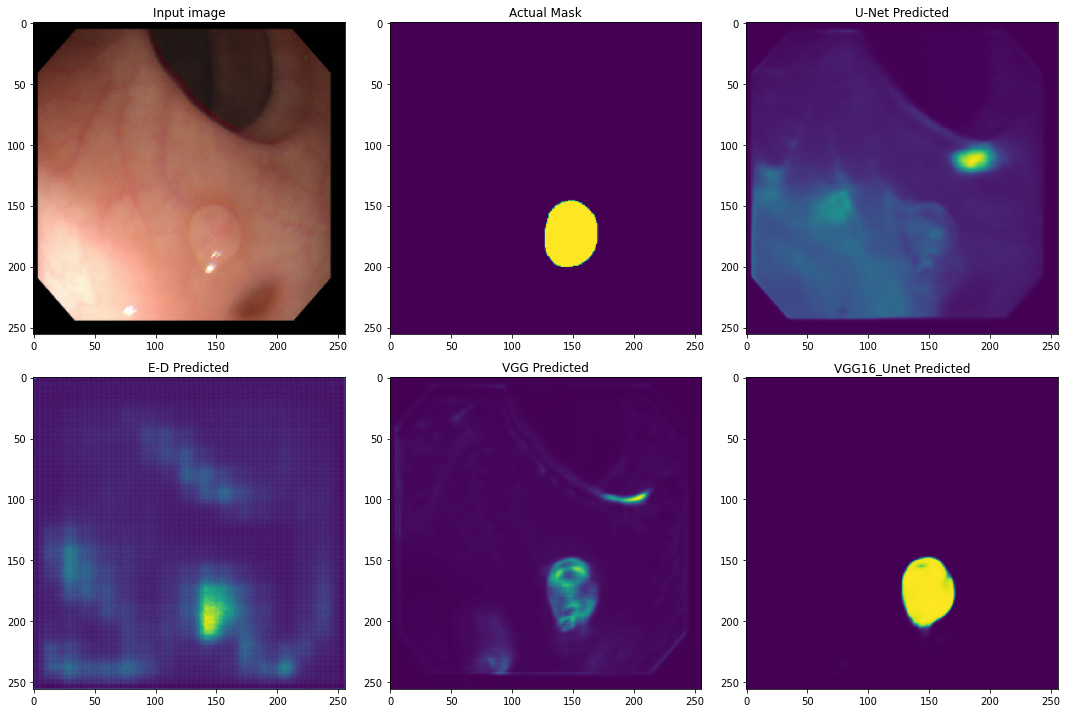

In [120]:
print_images()

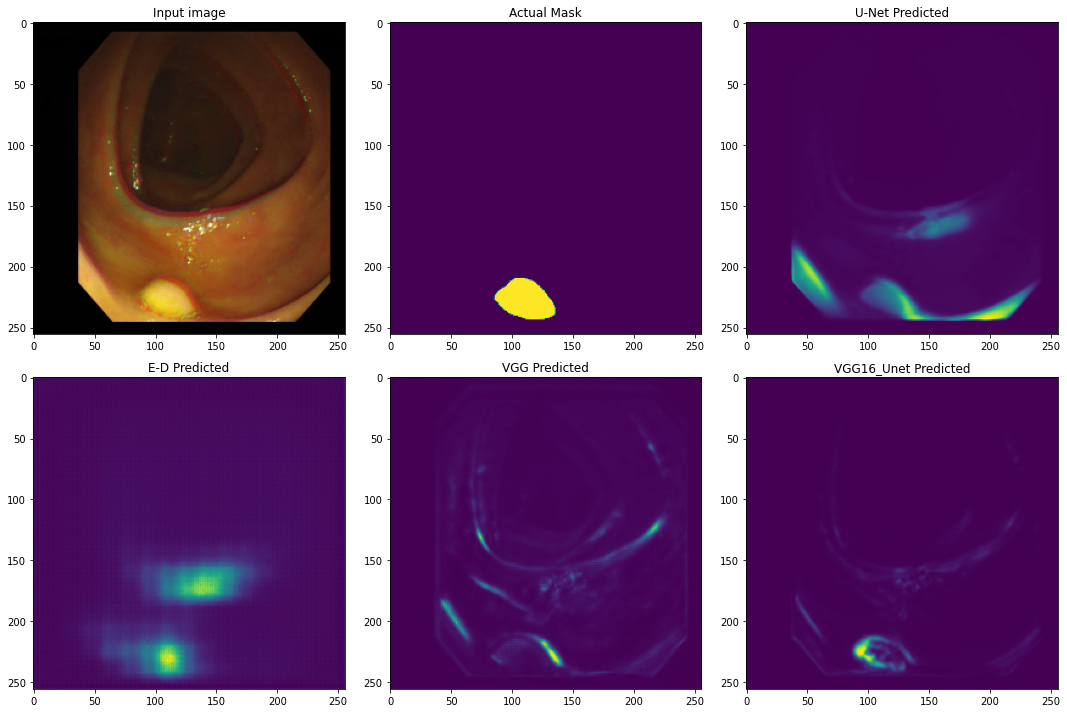

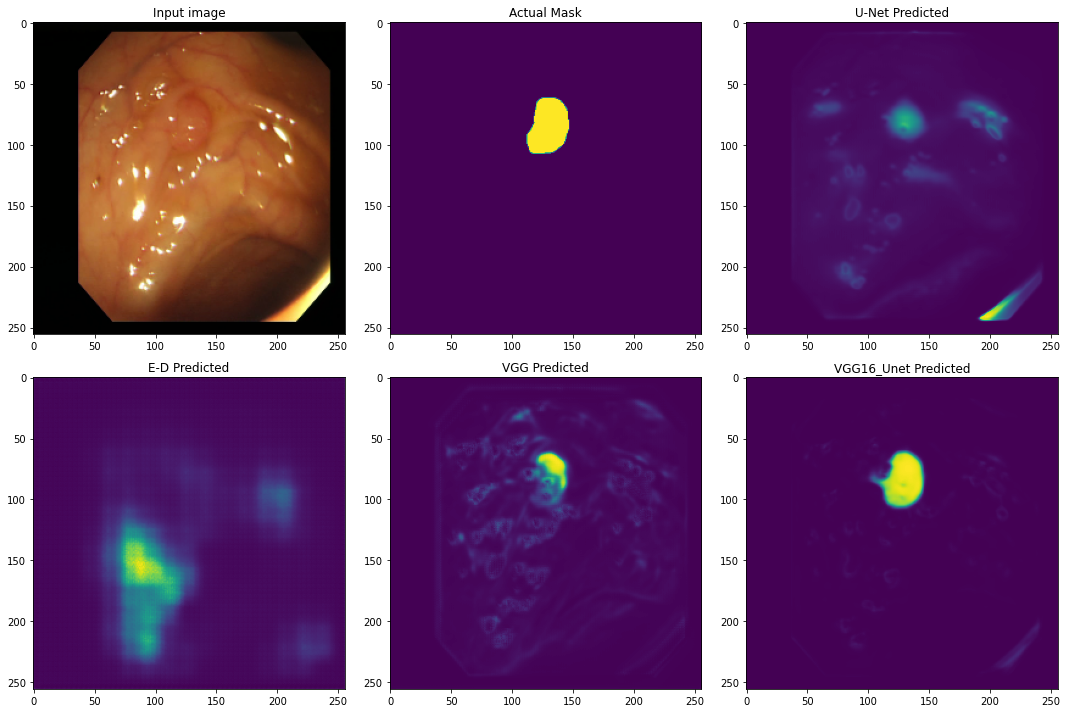

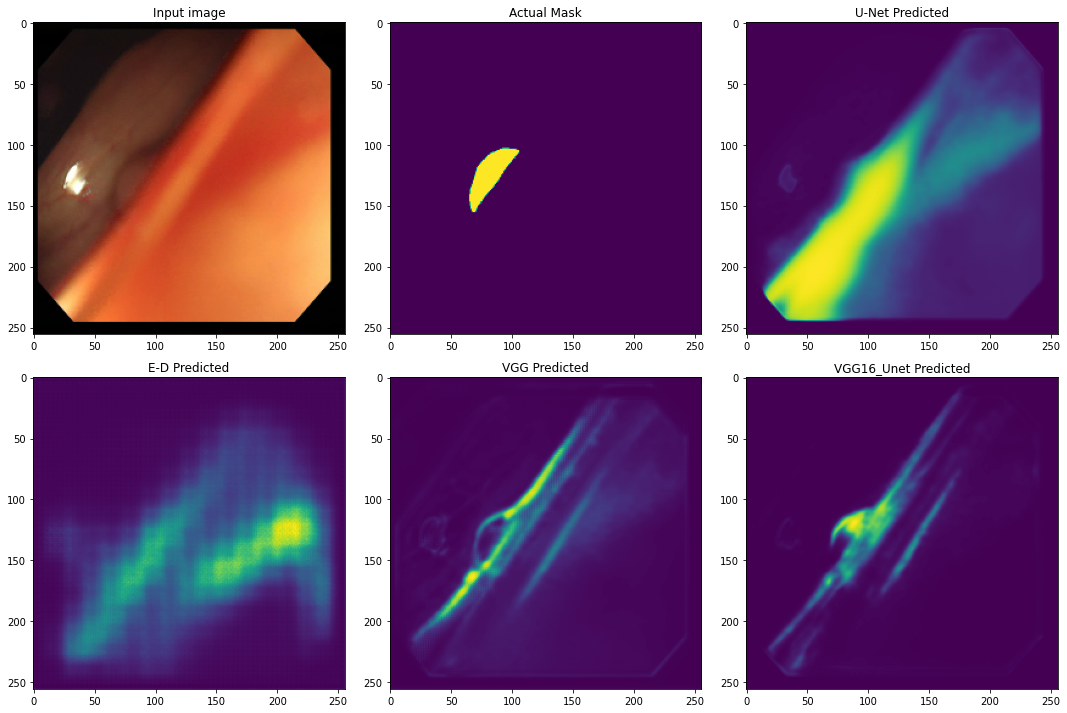

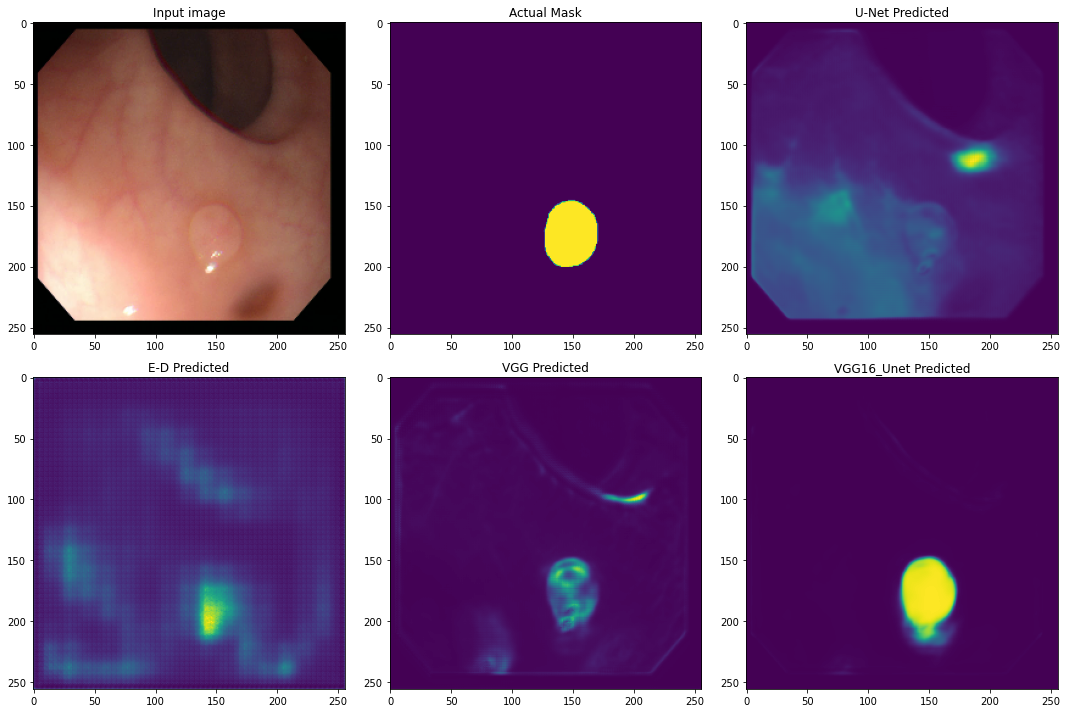

In [134]:
print_images()

# 회고

***오늘 사용해본 모델***
1. Encoder-Decoder 모델  
2. U-Net 모델  
3. VGG16 모델  
VGG16 모델에 추가로 가중치 설정을 해봄.
---

- 배운점 : 여러 모델을 사용해서 이미지 분류의 성능을 높여보았다.  
- 어렵고 아쉬운점 : dice손실 함수를 사용할 때 매번 선언해주지 않으면 오류가 나왔고, 모델 훈련중 GPU 메모리 초과로 인한 오류가 계속 생성되어 같은 부분에 계속 막혀 어려웠던 것 같다. 더 많은 배치사이즈로 못돌려 본 것이 아쉽다.  
- 느낀점 : 얼마전에 내시경으로 본 용종(?)이 생각나서 이런식으로 ai기술들이 사용되고 발전 되는구나 싶어 신기하였고, 코드는 아직도 어렵게 느껴진다.